In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

%matplotlib widget

In [2]:
from struct import *
import numpy as np

def ucitaj_mnist(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        broj_slika = unpack(">I", fp.read(4))[0]
        broj_redova = unpack(">I", fp.read(4))[0]
        broj_kolona = unpack(">I", fp.read(4))[0]
        
        slike = np.frombuffer(fp.read(broj_slika*broj_redova*broj_kolona), dtype=np.uint8).reshape((broj_slika, broj_redova, broj_kolona))
        slike = slike.astype(np.float32)/255
        return slike

def ucitaj_mnist_labele(putanja):
    with open(putanja, "rb") as fp:
        magic_number = unpack(">I", fp.read(4))
        broj_labela = unpack(">I", fp.read(4))[0]
        labele = np.frombuffer(fp.read(broj_labela), dtype=np.uint8)
        return labele
    
slike_trening = ucitaj_mnist("train-images.idx3-ubyte")
labele_trening = ucitaj_mnist_labele("train-labels.idx1-ubyte")

slike_test = ucitaj_mnist("train-images.idx3-ubyte")
labele_test = ucitaj_mnist_labele("train-labels.idx1-ubyte")

In [3]:
class MnistDataset(Dataset):
    def __init__(self, putanja_podaci, putanja_label):
        super().__init__()
        
        slike = ucitaj_mnist(putanja_podaci)
        labele = ucitaj_mnist_labele(putanja_label)
        
        self.podaci = list(zip(slike.reshape(len(slike), slike[0].shape[0]*slike[0].shape[1]), labele))
    
    def __len__(self):
        return len(self.podaci)
    
    def __getitem__(self, indeks):
        return self.podaci[indeks]

In [4]:
mnist_podaci = MnistDataset("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
mnist_podaci2 = MnistDataset("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

In [5]:
mnist_trening_podaci = DataLoader(mnist_podaci, batch_size=4, shuffle=True)
mnist_test_podaci = DataLoader(mnist_podaci2, batch_size=4, shuffle=True)

In [6]:
class Mreza(nn.Module):
    def __init__(self):
        super(Mreza, self).__init__()
        self.prvi_sloj = nn.Linear(28*28, 500)
        self.drugi_sloj = nn.Linear(500, 200)
        self.treci_sloj = nn.Linear(200, 100)
        self.cetvrti_sloj = nn.Linear(100, 10)
    
    def forward(self, x):
        prvi_sloj_izlaz = F.tanh(self.prvi_sloj(x))
        drugi_sloj_izlaz = F.tanh(self.drugi_sloj(prvi_sloj_izlaz))
        treci_sloj_izlaz = F.tanh(self.treci_sloj(drugi_sloj_izlaz))
        return F.tanh(self.cetvrti_sloj(treci_sloj_izlaz))
        

In [7]:
mreza = Mreza()

funkcija_greske = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mreza.parameters(), lr=0.001, momentum=0.9)

for epoha in range(1):
    for (x, y) in mnist_trening_podaci:
        predikcija = mreza(x)
        
        optimizer.zero_grad()
        greska = funkcija_greske(predikcija, y)
        greska.backward()
        optimizer.step()

e:\singidunum\materijali\ml-okruzenje\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [8]:
tacnih = 0

for el in mnist_test_podaci:
    rezultat = mreza(el[0])
    predikcija = torch.argmax(rezultat, 1)
    tacnih += (predikcija == el[1]).sum()

print(tacnih/len(mnist_podaci2))

tensor(0.9212)


In [9]:
class MnistDataset(Dataset):
    def __init__(self, putanja_podaci, putanja_label):
        super().__init__()
        
        slike = ucitaj_mnist(putanja_podaci)
        labele = ucitaj_mnist_labele(putanja_label)
        
        # prazne_slike = np.random.random((1000, 28, 28)).astype(np.float32)
        prazne_slike = np.zeros((1000, 28, 28)).astype(np.float32)
        labele_prazne = np.ones(1000, dtype=np.uint8)*10
        labele = np.concatenate((labele, labele_prazne))
        slike = np.concatenate((slike, prazne_slike))
        
        self.podaci = list(zip(slike.reshape(len(slike), 1, slike[0].shape[0], slike[0].shape[1]), labele))
    
    def __len__(self):
        return len(self.podaci)
    
    def __getitem__(self, indeks):
        return self.podaci[indeks]

mnist_podaci = MnistDataset("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
mnist_podaci2 = MnistDataset("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")
mnist_trening_podaci = DataLoader(mnist_podaci, batch_size=4, shuffle=True)
mnist_test_podaci = DataLoader(mnist_podaci2, batch_size=4, shuffle=True)

In [10]:
class CnnMreza(nn.Module):
    def __init__(self):
        super(CnnMreza, self).__init__()
        self.prvi_sloj = nn.Conv2d(1, 5, 3, padding=1)
        self.drugi_sloj = nn.Conv2d(5, 10, 3, padding=1)
        
        self.prvi_linearni_sloj = nn.Linear(10*28*28, 500)
        self.drugi_linearni_sloj = nn.Linear(500, 11)
    
    def forward(self, x):
        prvi_sloj_izlaz = F.tanh(self.prvi_sloj(x))
        drugi_sloj_izlaz = F.tanh(self.drugi_sloj(prvi_sloj_izlaz))
        treci_sloj_izlaz = F.tanh(self.prvi_linearni_sloj(drugi_sloj_izlaz.view(-1, 10*28*28)))
        return F.tanh(self.drugi_linearni_sloj(treci_sloj_izlaz))

In [11]:
mreza = CnnMreza()

funkcija_greske = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mreza.parameters(), lr=0.001, momentum=0.9)

for epoha in range(1):
    for (x, y) in mnist_trening_podaci:
        predikcija = mreza(x)
        
        optimizer.zero_grad()
        greska = funkcija_greske(predikcija, y)
        greska.backward()
        optimizer.step()

In [12]:
tacnih = 0

for el in mnist_test_podaci:
    rezultat = mreza(el[0])
    predikcija = torch.argmax(rezultat, 1)
    tacnih += (predikcija == el[1]).sum()

print(tacnih/len(mnist_podaci2))

tensor(0.9521)


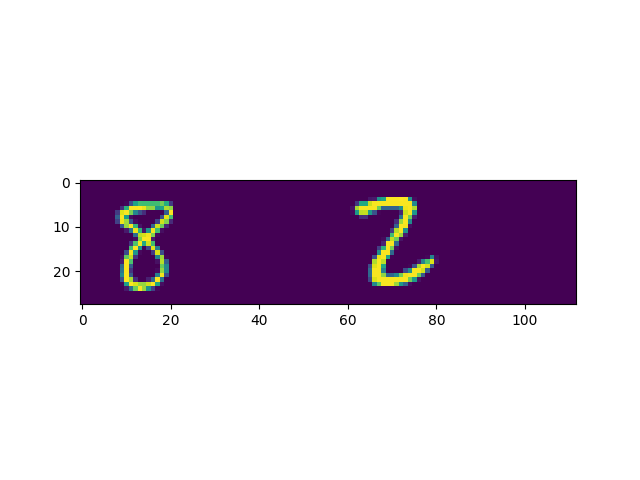

In [13]:
tablica = np.zeros((28, 28*4))
cifre = next(iter(mnist_trening_podaci))
for i, c in enumerate(cifre[0]):
    if i%2 == 0:
        tablica[0:28, i*28:(i+1)*28] = c.numpy()

plt.figure()
plt.imshow(tablica)
plt.show()

In [14]:
rezultat = []
for i in range(4):
    rezultat.append(mreza(torch.from_numpy(tablica[0:28, i*28:(i+1)*28].reshape(1, 28, 28).astype(np.float32))))
# print(rezultat)
print(list(map(lambda x: torch.argmax(x).item() if torch.argmax(x).item() < 10 else None, rezultat)))

[8, None, 2, None]


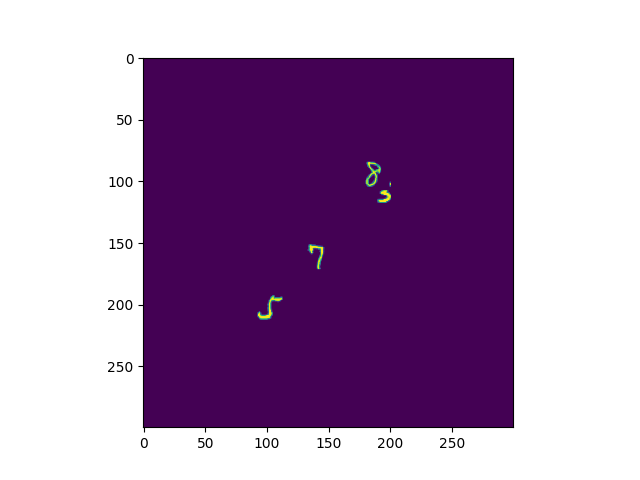

In [15]:
velika_slika = np.zeros((300, 300))

cifre = next(iter(mnist_trening_podaci))

koordinate = np.random.randint(0, 300-28, size=(4, 2))

for i, c in enumerate(cifre[0]):
    velika_slika[koordinate[i][0]:koordinate[i][0]+28, koordinate[i][1]:koordinate[i][1]+28,] = c.numpy()

plt.figure()
plt.imshow(velika_slika)
plt.show()

In [16]:
heatmapa = np.zeros((11, 300, 300))

for i in range(0, 300-28):
    for j in range(0, 300-28):
        mala_slika = torch.from_numpy(velika_slika[i:i+28, j:j+28].reshape(1, 28, 28).astype(np.float32))
        rezultat_za_heatmapu = mreza(mala_slika)
        
        max_vrednost = rezultat_za_heatmapu.max().item()
        indeks = torch.argmax(rezultat_za_heatmapu).item()
        if max_vrednost > 0.9:
            heatmapa[indeks][i:i+28, j:j+28] += 1

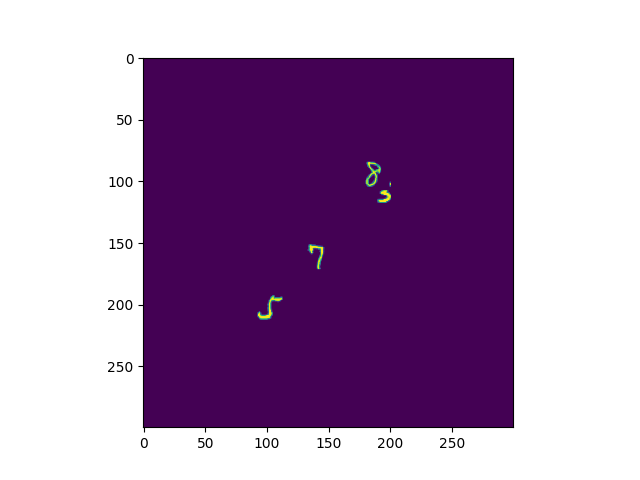

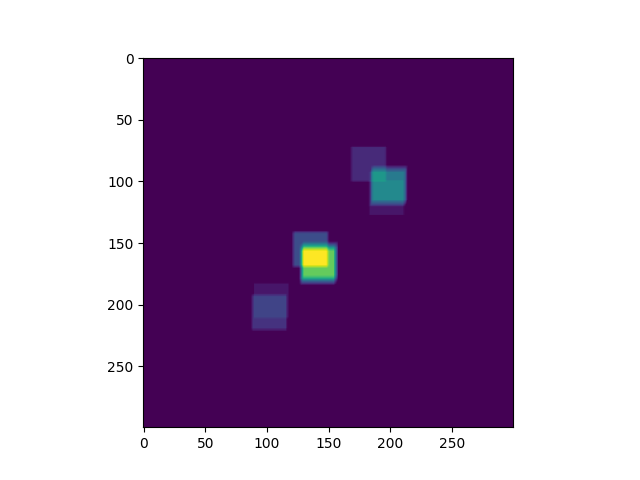

In [17]:
plt.figure()
plt.imshow(velika_slika)
plt.show()

plt.figure()
plt.imshow(heatmapa[1])
plt.show()